In [44]:
import sys
import os
import numpy as np
import getdist
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.join(os.path.dirname("__file__"), '../'))
from metrics import diff
from metrics import flow
from metrics import tension
from metrics.parameter_metrics import *
from metrics import utilities
from emulators import lsst
from emulators import cosmopower

In [31]:
path = '/home/grads/data/evan/mc_data/'
dir_list = os.listdir(path)

In [32]:
lsst_roots = []

for file in dir_list:
    if file.endswith('.txt'):
        lsst_roots.append(file[:-4])
        
print(lsst_roots)

# planck path
planck_path = '/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated'
lsst_planck_path = '/home/grads/data/evan/LSST_emulation/joint_data'

['noise_0.6827_4', 'noise_0.9973_31', 'noise_0.9545_39', 'noise_0.6827_18', 'noise_0.9545_17', 'noise_0.6827_34', 'noise_0.9545_38', 'noise_0.6827_39', 'noise_0.6827_1', 'noise_0.9545_29', 'noise_0.9545_22', 'noise_0.9973_27', 'noise_0.9973_1', 'noise_0.9545_28', 'noise_0.9973_29', 'noise_0.9973_11', 'noise_0.9545_7', 'noise_0.6827_37', 'noise_0.9545_13', 'fiducial', 'noise_0.9545_33', 'noise_0.9973_4', 'noise_0.9973_32', 'noise_0.9973_21', 'noise_0.6827_21', 'noise_0.9545_21', 'noise_0.6827_27', 'noise_0.9973_5', 'noise_0.6827_24', 'noise_0.9545_25', 'noise_0.9973_33', 'noise_0.9545_36', 'noise_0.6827_13', 'noise_0.9545_3', 'noise_0.9973_13', 'noise_0.6827_16', 'noise_0.9545_5', 'noise_0.9973_12', 'noise_0.9545_19', 'noise_0.6827_29', 'noise_0.9545_14', 'noise_0.9973_25', 'noise_0.9973_20', 'noise_0.6827_10', 'noise_0.9973_16', 'noise_0.9545_10', 'noise_0.9973_6', 'noise_0.6827_7', 'noise_0.9973_3', 'noise_0.6827_6', 'noise_0.9973_40', 'noise_0.6827_25', 'noise_0.9973_37', 'noise_0.68

In [40]:
# metric arrays
nf    = []
q_udm = []
qdmap = []
eigen = []

# priors for eigentension
priors = {'omegab':  [0.001, 0.04],
          'omegac':  [0.005, 0.99],
          'h':       [0.2,   1.0],
          'tau':     [0.01,  0.8],
          'ns':      [0.9,   1.1],
          'logA':    [1.61,  3.91],
          'Aplanck': [1.0,   0.01],
          'H0':      [55, 91],
         }

# instantiate diff
chains = diff.chain()
chain1 = chains.getdist_reader(planck_path)

for root in lsst_roots[:5]:
    chain2 = chains.getdist_reader(path+root)
    chains.chains = [chain1,chain2]
    chains.diff()
    
    # MAF
    maf = flow.MAF(len(chains.params))
    maf.setup(feedback=False)
    maf.train(chains.diff_chain,batch_size=5000,feedback=False)
    nsigma,high,low = tension.flow_significance(
                        maf.target_dist,
                        maf.gauss_bijector,
                        len(chains.params)
                        )
    #print(r"n_sigma = {:.5f} +{:.5f}/-{:.5f}".format(nsigma,high-nsigma,nsigma-low))
    nf.append(nsigma)
    
    # param update
    chain3 = chains.getdist_reader(lsst_planck_path)
    chain3.setParamNames(['omegab', 'omegac', 'logA', 'ns', 'H0', 'h', 'tau', 'Aplanck'])
    qudm_estimate = qudm(chain2,chain3,feedback=False)
    q_udm.append(qudm_estimate)

    # gof loss
    likea=0
    for param in chain1.getLikeStats().list():
        likea += chain1.getLikeStats().parWithName(param).bestfit_sample

    likeb=0
    for param in chain2.getLikeStats().list():
        likeb += chain2.getLikeStats().parWithName(param).bestfit_sample

    likeab=0
    for param in chain3.getLikeStats().list():
        likeab += chain3.getLikeStats().parWithName(param).bestfit_sample

    n_sigma = q_dmap(chain2,chain1,chain3,prior_dict=priors,lkl_a=likea,lkl_b=likeb,lkl_ab=likeab)
    qdmap.append(n_sigma)
    
    # eigentension
    nsigma,high,low = eigentension(chain2,chain1,priors,feedback=False)
    eigen.append(nsigma)

/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated.txt
Removed no burn in
/home/grads/data/evan/mc_data/noise_0.6827_4.txt
Removed no burn in

Params in first chain:
['omegab', 'omegac', 'h', 'tau', 'ns', 'logA', 'Aplanck']

Params in second chain:
['logA', 'ns', 'H0', 'omegab', 'omegac']

 Common params found:
['omegab', 'omegac', 'ns', 'logA']

N1 = 112800
N2 = 60000
[####################] Completed!                             
/home/grads/data/evan/LSST_emulation/joint_data.txt
Removed no burn in
Using given likelihoods.
Q_DMAP = 33.72652
dof = 4.37126
3 is robust!
adding the [0] eigenvector to well-measured subspace
Removed no burn in
Removed no burn in

Params in first chain:
['e3', 'e0']

Params in second chain:
['e3', 'e0']

 Common params found:
['e3', 'e0']

N1 = 112800
N2 = 60000
---   MADE info   ---
 - Hidden_units = [4, 4]
 - Activation = <function asinh at 0x7f2c4991fb00>

---   Model info   ---
 - N samples = 112800
 - Uniform weights = 1.0
 - Pre-Gaussian

In [41]:
print(nf)
print(q_udm)
print(qdmap)
print(eigen)

[1.8111347212500648, 1.5843679981581194, 1.032709214628025, 1.5193278218643358, 1.338664248492144]
[2.8318685489194473, 0.0, 0.6020705405547948, 3.0408720165277883, 2.104725431963157]
[4.83599418662725, 0.0, 0.5839739670451668, 1.137573071554474, 0.0]
[1.973048824026664, 1.2754217622784207, 1.2618576869625733, 1.871686415656289, 1.6420482746373428]


In [42]:
mean_nf = np.mean(nf)
std_nf = np.std(nf)

mean_qudm = np.mean(q_udm)
std_qudm = np.mean(q_udm)

mean_qdmap = np.mean(qdmap)
std_qdmap = np.mean(qdmap)

mean_eigen = np.mean(eigen)
std_eigen = np.mean(eigen)

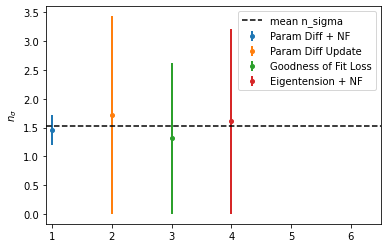

In [60]:
x = np.arange(1,5,1)
y = [mean_nf,mean_qudm,mean_qdmap,mean_eigen]
yerr = [std_nf,std_qudm,std_qdmap,std_eigen]
mean = np.mean([mean_nf,mean_qudm,mean_qdmap,mean_eigen])
plt.errorbar(x[0],mean_nf,yerr=std_nf,lw=0,elinewidth=2,marker='o',markersize=4,label='Param Diff + NF')
plt.errorbar(x[1],mean_qudm,yerr=std_qudm,lw=0,elinewidth=2,marker='o',markersize=4,label='Param Diff Update')
plt.errorbar(x[2],mean_qdmap,yerr=std_qdmap,lw=0,elinewidth=2,marker='o',markersize=4,label='Goodness of Fit Loss')
plt.errorbar(x[3],mean_eigen,yerr=std_eigen,lw=0,elinewidth=2,marker='o',markersize=4,label='Eigentension + NF')
plt.plot([0.9,6.5],[mean,mean],'k--',label='mean n_sigma')
plt.ylabel('$n_\sigma$')
plt.xlim([0.9, 6.5])
plt.legend()
plt.show()